# SIGNAL PROCESSING WITH GW150914 OPEN DATA 

Welcome! This ipython notebook (or associated python script GW150914_tutorial.py ) will go through some typical signal processing tasks on strain time-series data associated with the LIGO GW150914 data release from the LIGO Open Science Center (LOSC):

* https://losc.ligo.org/events/GW150914/

* View the tutorial as a web page - https://losc.ligo.org/s/events/GW150914/GW150914_tutorial.html/
* Download the tutorial as a python script - https://losc.ligo.org/s/events/GW150914/GW150914_tutorial.py/
* Download the tutorial as iPython Notebook - https://losc.ligo.org/s/events/GW150914/GW150914_tutorial.ipynb/

To begin, download the ipython notebook, readligo.py, and the data files listed below, into a directory / folder, then run it. Or you can run the python script GW150914_tutorial.py. You will need the python packages: numpy, scipy, matplotlib, h5py.

On Windows, or if you prefer, you can use a python development environment such as Anaconda (https://www.continuum.io/why-anaconda) or Enthought Canopy (https://www.enthought.com/products/canopy/). 

Questions, comments, suggestions, corrections, etc: email losc@ligo.caltech.edu

v20160208b

http://www.tapir.caltech.edu/~teviet/Waves/gwave.html

## Intro to signal processing

This tutorial assumes that you know python well enough. 

If you know how to use "ipython notebook", use the GW150914_tutorial.ipynb file. Else, you can use the GW150914_tutorial.py script.

This tutorial assumes that you know a bit about signal processing of digital time series data (or want to learn!). This includes power spectral densities, spectrograms, digital filtering, whitening, audio manipulation. This is a vast and complex set of topics, but we will cover many of the basics in this tutorial.

If you are a beginner, here are some resources from the web:
* http://101science.com/dsp.htm
* https://georgemdallas.wordpress.com/2014/05/14/wavelets-4-dummies-signal-processing-fourier-transforms-and-heisenberg/
* https://en.wikipedia.org/wiki/Signal_processing
* https://en.wikipedia.org/wiki/Spectral_density
* https://en.wikipedia.org/wiki/Spectrogram
* http://greenteapress.com/thinkdsp/
* https://en.wikipedia.org/wiki/Digital_filter

And, well, lots more - google it!

## Download the data

* Download the data files from LOSC:
* We will use the hdf5 files, both H1 and L1, with durations of 32 and 4096 seconds around GW150914, sampled at 16384 and 4096 Hz :
  * https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V1-1126259446-32.hdf5
  * https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_4_V1-1126259446-32.hdf5
  * https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_16_V1-1126259446-32.hdf5
  * https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_16_V1-1126259446-32.hdf5
  * https://losc.ligo.org/s/events/GW150914/GW150914_4_NR_waveform.txt
* Download the python functions to read the data: https://losc.ligo.org/s/sample_code/readligo.py
* From a unix/mac-osx command line, you can use wget; for example, 
  * wget https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V1-1126257414-4096.hdf5
* Put these files in your current directory / folder. Don't mix any other LOSC data files in this directory, or readligo.py may get confused.

Here, 
* "H-H1" means that the data come from the LIGO Hanford Observatory site and the LIGO "H1" datector; 
* the "_4_" means the strain time-series data are (down-)sampled from 16384 Hz to 4096 Hz;
* the "V1" means version 1 of this data release;
* "1126257414-4096" means the data starts at GPS time 1126257414 (Mon Sep 14 09:16:37 GMT 2015), duration 4096 seconds;
  * NOTE: GPS time is number of seconds since Jan 6, 1980 GMT. See http://www.oc.nps.edu/oc2902w/gps/timsys.html or https://losc.ligo.org/gps/ 
* the filetype "hdf5" means the data are in hdf5 format:
https://www.hdfgroup.org/HDF5/

Note that the the 4096 second long files at 16384 Hz sampling rate are fairly big files (125 MB). 
You won't need them for this tutorial:
* https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V1-1126257414-4096.hdf5
* https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_4_V1-1126257414-4096.hdf5
* https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_16_V1-1126257414-4096.hdf5
* https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_16_V1-1126257414-4096.hdf5


In [43]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# the ipython magic below must be commented out in the .py file, since it doesn't work.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

# LIGO-specific readligo.py 
import readligo as rl


*** <span style="color:red"> butter( lowcut, highcut, fs, order) : The Butterworth band-pass filter include the following parameters </span> ***

<a href=\"http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter">Reference here</a>

- sample_rate  $f_s$, 
- cutoff frequencies IN HERTZ 
- order 
- *** <span style="color:blue">(other parameters, like attenuation, natural frequency) </span> ***


ex :
`def butter_bandpass(lowcut, highcut, fs, order=5):`

    nyq = 0.5 * fs
    
    low = lowcut / nyq
    
    high = highcut / nyq
    
    b, a = butter(order, [low, high], btype='band')
    
    return b, a
    
 
 
*** <span style="color:red"> freqz(b, a, worN=p) : uses an FFT-based algorithm to calculate the Z-transform frequency response of a digital filter.</span> ***

<a href=\"http://stackoverflow.com/questions/25215681/scipy-bilinear-transformation-incorrect-at-low-frequencies-and-high-sampling-rat">Reference here</a>

 `[h, w] = freqz(b, a, worN=p)`
 
 `f = fs * w / (2*np.pi)`
 
 $H(e^{j \omega}) = {{\sum^N_{n=1} a[n]e^{-j \omega n}} \over {{\sum^N_{n=1} b[n]e^{-j \omega n}}}}$
 
 * $f = {f_s  w \over {2 \pi}}$
 
 * p : the p-point complex frequency response
 
 * b : denominator coefficients
 
 * a : numerator coefficients (a = 1 : FIR)
 
 
  
*** <span style="color:red"> zpk2tf(z, p, k) : Return polynomial transfer function representation from zeros and poles.</span> ***
 
  
**<span style="color:blue"> i.e : return Numerator polynomial b and Denominator polynomial a.<span>**
 
$H(s) = {{\prod^N_{n=1} (s - z[n])} \over {{\prod^M_{m=1} (s - z[m])}}} = {{\sum^N_{n=1} a[n]z^n} \over {{\sum^M_{m=1} b[m] z^m}}}$

 
 * Z : zeros
 
 * P : poles
 
 * K : gain(s)
 
 * b : denominator coefficients
 
 * a : numerator coefficients


*** <span style="color:red"> y = filtfilt( b, a, x) : performs zero-phase digital filtering by processing the input data, x.</span> ***

 <a href=\"http://dsp.stackexchange.com/questions/19084/applying-filter-in-scipy-signal-use-lfilter-or-filtfilt" >Reference here</a>  
   
   
**<span style="color:blue"> filtfilt is zero-phase filtering, which doesn't shift the signal as it filters. Since the phase is zero at all frequencies, it is also linear-phase. Filtering backwards in time requires you to predict the future, so it can't be used in "online" real-life applications, only for offline processing of recordings of signals.<span>**

**<span style="color:green"> lfilter is causal forward-in-time filtering only, similar to a real-life electronic filter. It is usually not linear-phase, adding a delay to the signal at some frequencies.<span>**

 * X : input
 
 * b : denominator coefficients
 
 * a : numerator coefficients
 

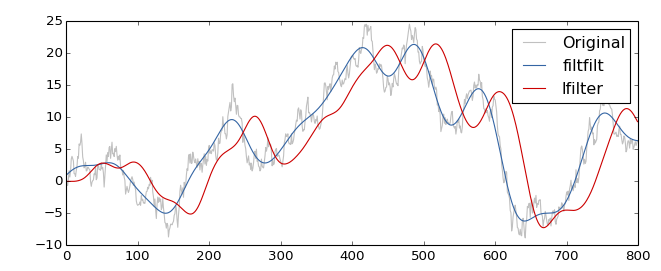

In [44]:
from IPython.display import Image
Image(filename='filt.png')

*** <span style="color:red"> Filters = iirdesign( wp, ws, gpass, gstop, analog=False, ftype='ellip', output='ba') : Complete IIR digital and analog filter design.</span> ***

 <a href=\"https://www.dsprelated.com/showarticle/164.php" >Reference here</a>  
 <a href=\"http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirdesign.html#scipy.signal.iirdesign" >Reference here 2</a> 
   
   
**<span style="color:blue"> The iirdesign takes our filter specifications and uses one of the IIR filter design methods to generate the coefficients.  The design methods determine the order of the filter.  The iirfilter function will take the desired order.  There are other functions to help determine the order per the specifications.  The response will be based off the order vs. trying to achieve some set of specifications.<span>**


`# Specification for our filter`

    Wp = 0.270   # end of passband, normalized frequency

    Ws = 0.412   # start of the stopband, normalized frequency 

    Rp = 0.1     # passband maximum loss (gpass)

    As = 60      # stoppand min attenuation (gstop)


`# The ellip and cheby2 filter design`
    
    Filters = iirdesign(Wp, Ws, Rp, As, ftype='ellip')

* Wp :  end of passband, normalized frequency
* Ws : start of the stopband, normalized frequency 
* Rp : passband maximum loss (gpass)
* As : stoppand min attenuation (gstop)
* ftype : filter type

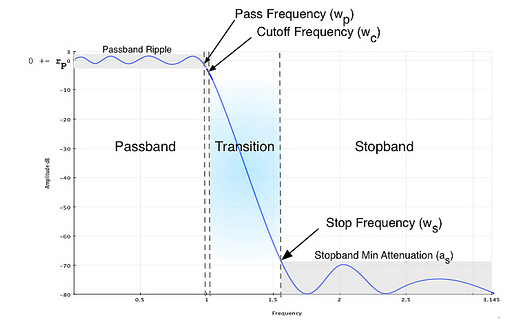

In [45]:
from IPython.display import Image
Image(filename='iir.png')

*** <span style="color:red"> psd(Data,Frequencies) : Power Spectral Density Estimates uing Welch’s average periodogram.</span> ***

* uses the power spectral density estimation data contained in Data and Frequencies vectors.

http://matplotlib.org/api/mlab_api.html

**NOTE** that in general, LIGO strain time series data has gaps (filled with NaNs) when the detectors are not taking valid ("science quality") data. Analyzing these data requires the user to loop over "segments" of valid data stretches. In https://losc.ligo.org/segments/ we provide example code to do this. 

**However**, the 4096 seconds of released data around GW150914 is one unbroken segment, with no gaps. So for now, we will read it all in and treat it as one valid data segment, ignoring the extra complexity mentioned above.

**This won't work** for other LOSC data releases! See https://losc.ligo.org/segments/ for a more general way to find valid data segments in LOSC data.

In [46]:
#----------------------------------------------------------------
# Load LIGO data from a single file
#----------------------------------------------------------------
# First from H1
fn_H1 = 'H-H1_LOSC_4_V1-1126259446-32.hdf5'
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
# and then from L1
fn_L1 = 'L-L1_LOSC_4_V1-1126259446-32.hdf5'
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

# sampling rate:
fs = 4096
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]
print dt
print 1/float(fs)

0.000244140625
0.000244140625


**<span style="color:blue"> The most common parameter describing the amplitude is a dimensionless "strain" h.<span>**


## Adding a numerical relativity template

Now let's also read in a theoretical (numerical relativity) template, 
generated with parameters favored by the output from the GW150914 parameter estimation (see the GW150914 detection paper, https://dcc.ligo.org/P150914/public ).

This NR template corresponds to the signal expected from a pair of black holes with masses of around 36 and 29 solar masses, merging into a single black hole of 62 solar masses, at a distance of around 410 Mpc. 

You can fetch the template time series from the following URL, and put it in your working directory / folder:
* https://losc.ligo.org/s/events/GW150914/GW150914_4_NR_waveform.txt


In [47]:
# read in the NR template
NRtime, NR_H1 = np.genfromtxt('GW150914_4_NR_waveform.txt').transpose()

## First look at the data from H1 and L1

In [48]:
# First, let's look at the data and print out some stuff:

# this doesn't seem to work for scientific notation:
# np.set_printoptions(precision=4)

print '  time_H1: len, min, mean, max = ', \
   len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max()
print 'strain_H1: len, min, mean, max = ', \
   len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max()
print 'strain_L1: len, min, mean, max = ', \
   len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max()
    
#What's in chan_dict? See https://losc.ligo.org/archive/dataset/GW150914/
bits = chan_dict_H1['DATA']
print 'H1     DATA: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max()
bits = chan_dict_H1['CBC_CAT1']
print 'H1 CBC_CAT1: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max()
bits = chan_dict_H1['CBC_CAT2']
print 'H1 CBC_CAT2: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max()
bits = chan_dict_L1['DATA']
print 'L1     DATA: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max()
bits = chan_dict_L1['CBC_CAT1']
print 'L1 CBC_CAT1: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max()
bits = chan_dict_L1['CBC_CAT2']
print 'L1 CBC_CAT2: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max()
print 'In both H1 and L1, all 32 seconds of data are present (DATA=1), '
print "and all pass data quality (CBC_CAT1=1 and CBC_CAT2=1)."

  time_H1: len, min, mean, max =  131072 1126259446.0 1126259462.0 1126259478.0
strain_H1: len, min, mean, max =  131072 -7.11996338709e-19 8.73279794057e-23 7.71483633765e-19
strain_L1: len, min, mean, max =  131072 -2.6788089173e-18 -1.82870749189e-18 -7.69266177024e-19
H1     DATA: len, min, mean, max =  32 1 1.0 1
H1 CBC_CAT1: len, min, mean, max =  32 1 1.0 1
H1 CBC_CAT2: len, min, mean, max =  32 1 1.0 1
L1     DATA: len, min, mean, max =  32 1 1.0 1
L1 CBC_CAT1: len, min, mean, max =  32 1 1.0 1
L1 CBC_CAT2: len, min, mean, max =  32 1 1.0 1
In both H1 and L1, all 32 seconds of data are present (DATA=1), 
and all pass data quality (CBC_CAT1=1 and CBC_CAT2=1).


#### Description: 
Each file in this dataset has duration 4096 seconds, meaning 16777216 samples in the strain h(t) time series, and 4096 points in the data quality time series. There are 7 bits in the data quality bitmask, and 5 bits in the injection bitmask.


Bit	Short Name	Description

Data Quality Bits

    0	DATA	data present
    1	CBC_CAT1	passes cbc CAT1 test
    2	CBC_CAT2	passes cbc CAT2 test
    3	CBC_CAT3	passes cbc CAT3 test
    4	BURST_CAT1	passes burst CAT1 test
    5	BURST_CAT2	passes burst CAT2 test
    6	BURST_CAT3	passes burst CAT3 test

Injection Bits

    0	NO_CBC_HW_INJ	no cbc injections
    1	NO_BURST_HW_INJ	no burst inejctions
    2	NO_DETCHAR_HW_INJ	no detchar injections
    3	NO_CW_HW_INJ	no continuous wave injections
    4	NO_STOCH_HW_INJ	no stoch injection

In [49]:
import pprint

tags = {"shortName":"GW150914", "version":"1", "release":"1", "description":" ", 
        "duration":4096, "npoints":16777216, "npointsQI":4096, "dqbits":7, "injbits":5, 
        "bits":[ {"mask":1, "bit":0, "shortName":"NO_CBC_HW_INJ", "description":"no cbc injections"} , 
                {"mask":0, "bit":0, "shortName":"DATA", "description":"data present"} , 
                {"mask":1, "bit":1, "shortName":"NO_BURST_HW_INJ", "description":"no burst inejctions"} , 
                {"mask":0, "bit":1, "shortName":"CBC_CAT1", "description":"passes cbc CAT1 test"} , 
                {"mask":1, "bit":2, "shortName":"NO_DETCHAR_HW_INJ", "description":"no detchar injections"} , 
                {"mask":0, "bit":2, "shortName":"CBC_CAT2", "description":"passes cbc CAT2 test"} , 
                {"mask":1, "bit":3, "shortName":"NO_CW_HW_INJ", "description":"no continuous wave injections"} , 
                {"mask":0, "bit":3, "shortName":"CBC_CAT3", "description":"passes cbc CAT3 test"} , 
                {"mask":1, "bit":4, "shortName":"NO_STOCH_HW_INJ", "description":"no stoch injection"} , 
                {"mask":0, "bit":4, "shortName":"BURST_CAT1", "description":"passes burst CAT1 test"} , 
                {"mask":0, "bit":5, "shortName":"BURST_CAT2", "description":"passes burst CAT2 test"} , 
                {"mask":0, "bit":6, "shortName":"BURST_CAT3", "description":"passes burst CAT3 test"} ]}
pprint.pprint(tags)

{'bits': [{'bit': 0,
           'description': 'no cbc injections',
           'mask': 1,
           'shortName': 'NO_CBC_HW_INJ'},
          {'bit': 0,
           'description': 'data present',
           'mask': 0,
           'shortName': 'DATA'},
          {'bit': 1,
           'description': 'no burst inejctions',
           'mask': 1,
           'shortName': 'NO_BURST_HW_INJ'},
          {'bit': 1,
           'description': 'passes cbc CAT1 test',
           'mask': 0,
           'shortName': 'CBC_CAT1'},
          {'bit': 2,
           'description': 'no detchar injections',
           'mask': 1,
           'shortName': 'NO_DETCHAR_HW_INJ'},
          {'bit': 2,
           'description': 'passes cbc CAT2 test',
           'mask': 0,
           'shortName': 'CBC_CAT2'},
          {'bit': 3,
           'description': 'no continuous wave injections',
           'mask': 1,
           'shortName': 'NO_CW_HW_INJ'},
          {'bit': 3,
           'description': 'passes cbc CAT3 test',


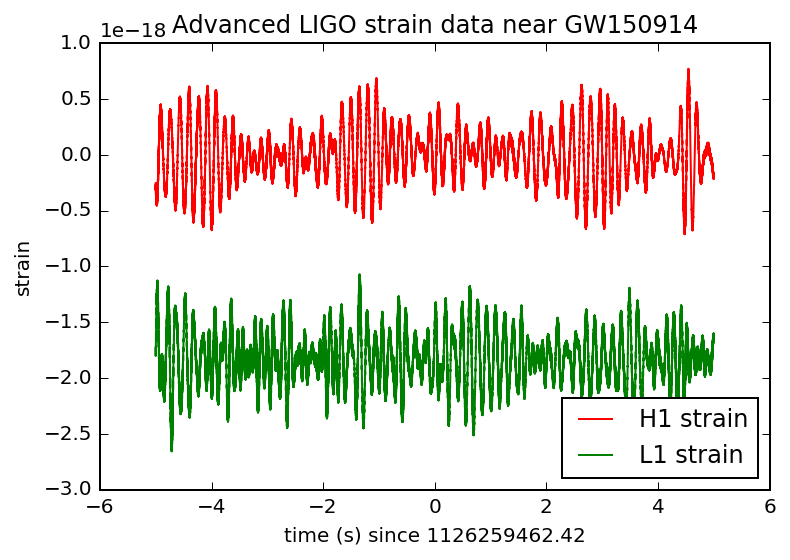

In [50]:
# plot +- 5 seconds around the event:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 5.                     # seconds around the event
# index into the strain time series for this time interval:
indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

plt.figure()
plt.plot(time_H1[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
plt.plot(time_L1[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend(loc='lower right')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_strain.png')

The data are dominated by **low frequency noise**; there is no way to see a signal here, without some signal processing.

There are very low frequency oscillations that are putting the mean of the L1 strain at -2.0e-18 at the time around this event, so it appears offset from the H1 strain. These low frequency oscillations are essentially ignored in LIGO data analysis (see bandpassing, below).

We will be "whitening" the data, below. 

## Data in the Fourier domain - ASDs

Plotting these data in the Fourier domain gives us an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD.

The ASDs are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data.

They are an estimate of the "strain-equivalent noise" of the detectors versus frequency,
which limit the ability of the detectors to identify GW signals.

They are in units of strain/rt(Hz).
So, if you want to know the root-mean-square (rms) strain noise in a frequency band,
integrate (sum) the squares of the ASD over that band, then take the square-root.

There's a signal in these data! 
For the moment, let's ignore that, and assume it's all noise.

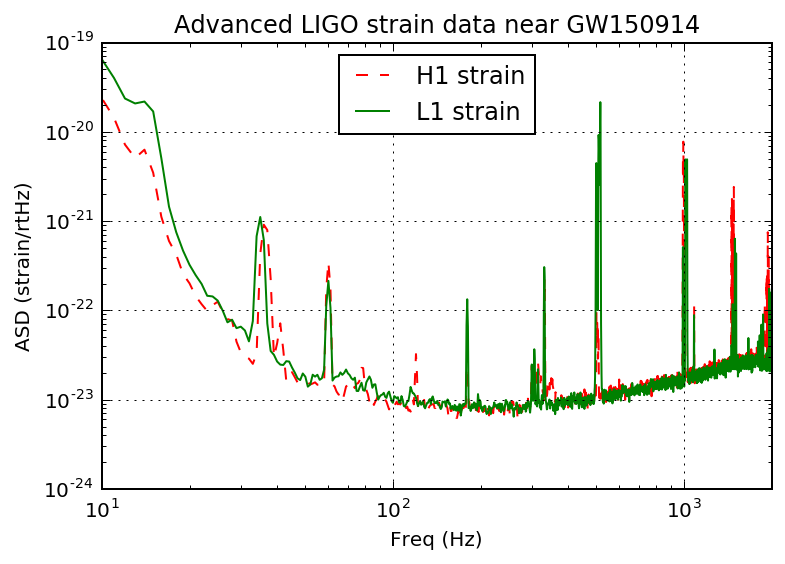

In [51]:
# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000
Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)


# plot the ASDs:
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx_H1),'--r',label='H1 strain')
plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_ASDs.png')

NOTE that we only plot the data between fmin = 10 Hz and fmax = 2000 Hz.

Below fmin, the data **are not properly calibrated**. That's OK, because the noise is so high below fmin that LIGO cannot sense gravitational wave strain from astrophysical sources in that band.

The sample rate is fs = 4096 Hz (2^12 Hz), so the data cannot capture frequency content above the Nyquist frequency = fs/2 = 2048 Hz. That's OK, because GW150914 only has detectable frequency content in the range 20 Hz - 300 Hz.

You can see strong spectral lines in the data; they are all of instrumental origin. Some are engineered into the detectors (mirror suspension resonances at ~500 Hz and harmonics, calibration lines, control dither lines, etc) and some (60 Hz and harmonics) are unwanted. We'll return to these, later.

You can't see the signal in this plot, since it is relatively weak and less than a second long, while this plot averages over 32 seconds of data. So this plot is entirely dominated by instrumental noise.

Later on in this tutorial, we'll look at the data sampled at the full 16384 Hz (2^14 Hz).

## Whitening

From the ASD above, we can see that the data are very strongly "colored" - noise fluctuations are much larger at low and high frequencies and near spectral lines, reaching a roughly flat ("white") minimum in the band around 80 to 300 Hz.

We can "whiten" the data (dividing it by the noise amplitude spectrum, in the fourier domain), suppressing the extra noise at low frequencies and at the spectral lines, to better see the weak signals in the most sensitive band.

Whitening is always one of the first steps in astrophysical data analysis (searches, parameter estimation).
Whitening requires no prior knowledge of spectral lines, etc; only the data are needed.

The resulting time series is no longer in units of strain; now in units of "sigmas" away from the mean.

In [52]:
# function to writen data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

# now whiten the data from H1 and L1, and also the NR template:
strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
NR_H1_whiten = whiten(NR_H1,psd_H1,dt)

Now plot the whitened strain data, along with the best-fit numerical relativity (NR) template.

To get rid of remaining high frequency noise, we will also bandpass the data (see bandpassing, below).

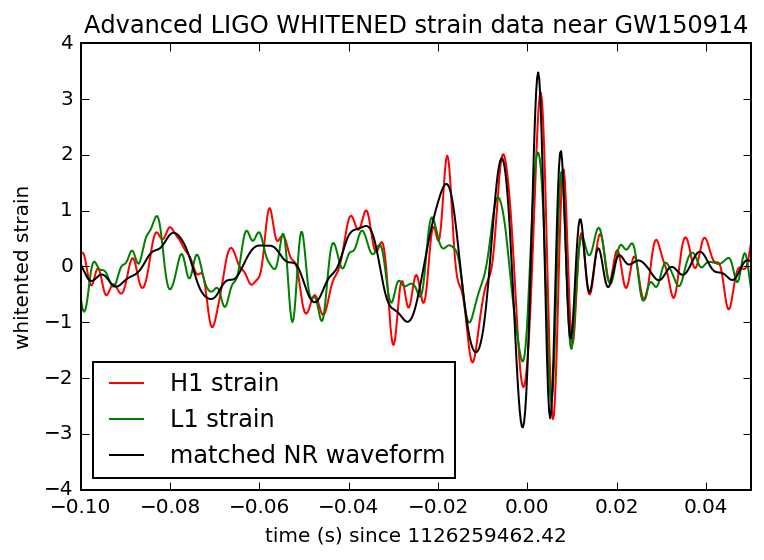

In [53]:
# We need to suppress the high frequencies with some bandpassing:
bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)
strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten)
NR_H1_whitenbp = filtfilt(bb, ab, NR_H1_whiten)

# plot the data after whitening:
# first, shift L1 by 7 ms, and invert. See the GW150914 detection paper for why!
strain_L1_shift = -np.roll(strain_L1_whitenbp,int(0.007*fs))

plt.figure()
plt.plot(time-tevent,strain_H1_whitenbp,'r',label='H1 strain')
plt.plot(time-tevent,strain_L1_shift,'g',label='L1 strain')
plt.plot(NRtime+0.002,NR_H1_whitenbp,'k',label='matched NR waveform')
plt.xlim([-0.1,0.05])
plt.ylim([-4,4])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('Advanced LIGO WHITENED strain data near GW150914')
plt.savefig('GW150914_strain_whitened.png')

The signal is now clearly visible in the whitened and bandpassed data. The "DC" offset between H1 and L1 data visible in the first plot is no longer visible here; the bandpassing cuts off frequency components below around 20 Hz and above 300 Hz. 

The signal is visible as an oscillation sweeping from low to high frequency from -0.10 seconds to 0, then damping down into the random noise. 

The signal looks roughly the same in both detectors. We had to shift the L1 data by 7 ms to get it to line up with the data from H1, because the source is roughly in the direction of the line connecting H1 to L1, and the wave travels at the speed of light, so it hits L1 7 ms earlier. Also, the orientation of L1 with respect to H1 means that we have to flip the sign of the signal in L1 for it to match the signal in H1.

It's exactly the kind of signal we expect from the inspiral, merger and ringdown of two massive black holes, as evidenced by the good match with the numerical relativity (NR) waveform, in black.

LIGO uses a rather elaborate software suite to match the data against a family of such signal waveforms ("templates"), to find the best match. This procedure helps LIGO to "optimally" separate signals from instrumental noise, and to infer the parameters of the source (masses, spins, sky location, orbit orientation, etc) from the best match templates.

## Spectrograms

Now let's plot a short time-frequency spectrogram around GW150914:

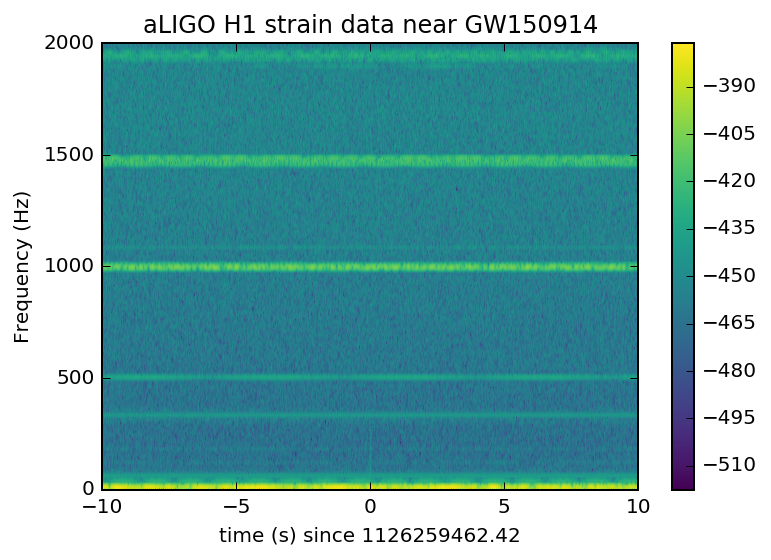

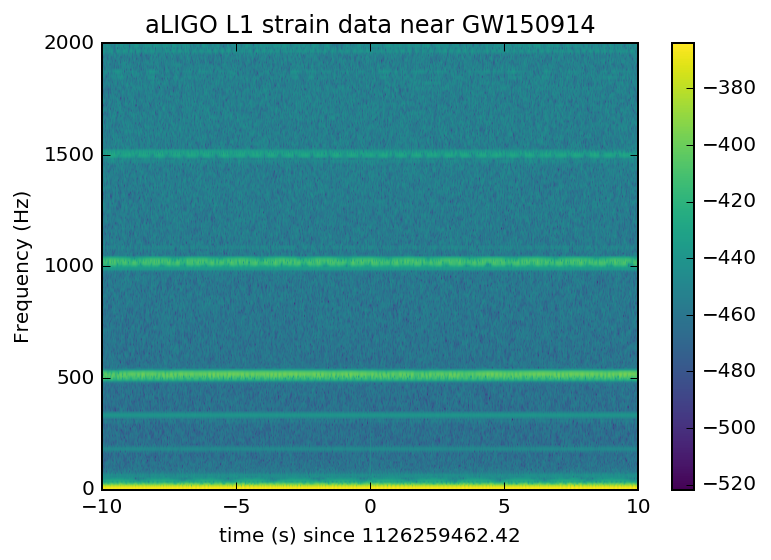

In [54]:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 10.                    # seconds around the event
# index into the strain time series for this time interval:
indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

# pick a shorter FTT time interval, like 1/8 of a second:
NFFT = fs/8
# and with a lot of overlap, to resolve short-time features:
NOVL = NFFT*15/16
# and choose a window that minimizes "spectral leakage" 
# (https://en.wikipedia.org/wiki/Spectral_leakage)
window = np.blackman(NFFT)

# the right colormap is all-important! See:
# http://matplotlib.org/examples/color/colormaps_reference.html
# viridis seems to be the best for our purposes, but it's new; if you don't have it, you can settle for ocean.
spec_cmap='viridis'
#spec_cmap='ocean'

# Plot the H1 spectrogram:
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_H1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 2000])
plt.title('aLIGO H1 strain data near GW150914')
plt.savefig('GW150914_H1_spectrogram.png')

# Plot the L1 spectrogram:
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_L1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 2000])
plt.title('aLIGO L1 strain data near GW150914')
plt.savefig('GW150914_L1_spectrogram.png')


In the above spectrograms, you can see lots of excess power below ~20 Hz, as well as strong spectral lines at 500, 1000, 1500 Hz (also evident in the ASDs above). The lines at multiples of 500 Hz are the harmonics of the "violin modes" of the fibers holding up the mirrors of the LIGO interferometers.

The signal is just bately visible here, at time=0 and below 500 Hz. We need to zoom in around the event time, and to the frequency range from [20, 400] Hz, and use the whitened data generated above.

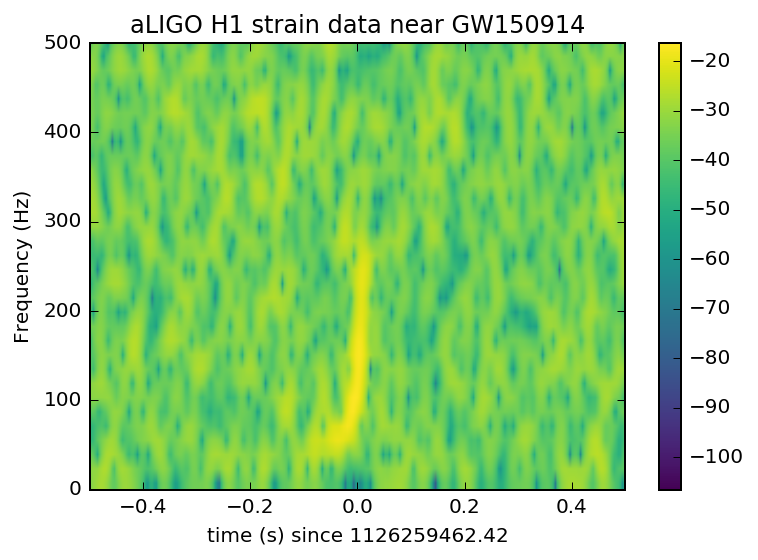

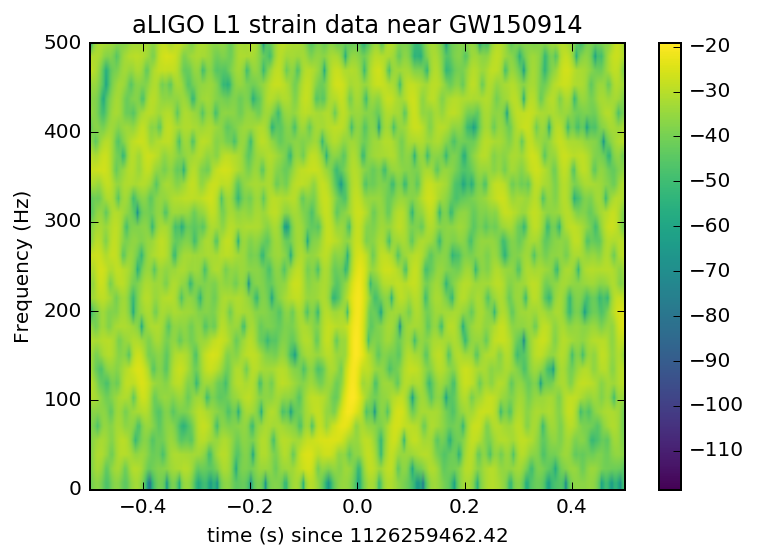

In [55]:
#  plot the whitened data, zooming in on the signal region:
tevent = 1126259462.422          # Mon Sep 14 09:50:45 GMT 2015 
deltat = 10.                      # seconds around the event
# index into the strain time series for this time interval:
indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

# pick a shorter FTT time interval, like 1/16 of a second:
NFFT = fs/16
# and with a lot of overlap, to resolve short-time features:
NOVL = NFFT*15/16
# and choose a window that minimizes "spectral leakage" 
# (https://en.wikipedia.org/wiki/Spectral_leakage)
window = np.blackman(NFFT)

# Plot the H1 whitened spectrogram around the signal
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_H1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-0.5, 0.5, 0, 500])
plt.title('aLIGO H1 strain data near GW150914')
plt.savefig('GW150914_H1_spectrogram_whitened.png')

# Plot the L1 whitened spectrogram around the signal
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_L1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-0.5, 0.5, 0, 500])
plt.title('aLIGO L1 strain data near GW150914')
plt.savefig('GW150914_L1_spectrogram_whitened.png')


See the smudge between -0.2 and 0 seconds? That's our signal!
You can see it 'chirping' from lower to higher frequency over a small fraction of a second.

## Time-domain filtering - Bandpassing+notching

Now let's filter the signal in the time domain, using bandpassing to reveal the signal in the frequency band [40 , 300 Hz], and notching of spectral lines to remove those noise sources from the data.

In [56]:
# generate linear time-domain filter coefficients, common to both H1 and L1.
# First, define some functions:

# This function will generate digital filter coefficients for bandstops (notches).
# Understanding it requires some signal processing expertise, which we won't get into here.
def iir_bandstops(fstops, fs, order=4):
    """ellip notch filter
    fstops is a list of entries of the form [frequency (Hz), df, df2]                           
    where df is the pass width and df2 is the stop width (narrower                              
    than the pass width). Use caution if passing more than one freq at a time,                  
    because the filter response might behave in ways you don't expect.
    """
    nyq = 0.5 * fs

    # Zeros zd, poles pd, and gain kd for the digital filter
    zd = np.array([])
    pd = np.array([])
    kd = 1

    # Notches
    for fstopData in fstops:
        fstop = fstopData[0]
        df = fstopData[1]
        df2 = fstopData[2]
        low = (fstop - df) / nyq
        high = (fstop + df) / nyq
        low2 = (fstop - df2) / nyq
        high2 = (fstop + df2) / nyq
        z, p, k = iirdesign([low,high], [low2,high2], gpass=1, gstop=6,
                            ftype='ellip', output='zpk')
        zd = np.append(zd,z)
        pd = np.append(pd,p)

    # Set gain to one at 100 Hz...better not notch there                                        
    bPrelim,aPrelim = zpk2tf(zd, pd, 1)
    outFreq, outg0 = freqz(bPrelim, aPrelim, 100/nyq)

    # Return the numerator and denominator of the digital filter                                
    b,a = zpk2tf(zd,pd,k)
    return b, a

def get_filter_coefs(fs):
    
    # assemble the filter b,a coefficients:
    coefs = []

    # bandpass filter parameters
    lowcut=43
    highcut=260
    order = 4

    # bandpass filter coefficients 
    nyq = 0.5*fs
    low = lowcut / nyq
    high = highcut / nyq
    bb, ab = butter(order, [low, high], btype='band')
    coefs.append((bb,ab))

    # Frequencies of notches at known instrumental spectral line frequencies.
    # You can see these lines in the ASD above, so it is straightforward to make this list.
    notchesAbsolute = np.array(
        [14.0,34.70, 35.30, 35.90, 36.70, 37.30, 40.95, 60.00, 
         120.00, 179.99, 304.99, 331.49, 510.02, 1009.99])

    # notch filter coefficients:
    for notchf in notchesAbsolute:                      
        bn, an = iir_bandstops(np.array([[notchf,1,0.1]]), fs, order=4)
        coefs.append((bn,an))

    # Manually do a wider notch filter around 510 Hz etc.          
    bn, an = iir_bandstops(np.array([[510,200,20]]), fs, order=4)
    coefs.append((bn, an))

    # also notch out the forest of lines around 331.5 Hz
    bn, an = iir_bandstops(np.array([[331.5,10,1]]), fs, order=4)
    coefs.append((bn, an))
    
    return coefs

# and then define the filter function:
def filter_data(data_in,coefs):
    data = data_in.copy()
    for coef in coefs:
        b,a = coef
        # filtfilt applies a linear filter twice, once forward and once backwards.
        # The combined filter has linear phase.
        data = filtfilt(b, a, data)
    return data


To visualize the effect of this filter, let's generate "white" gaussian noise, and filter it.

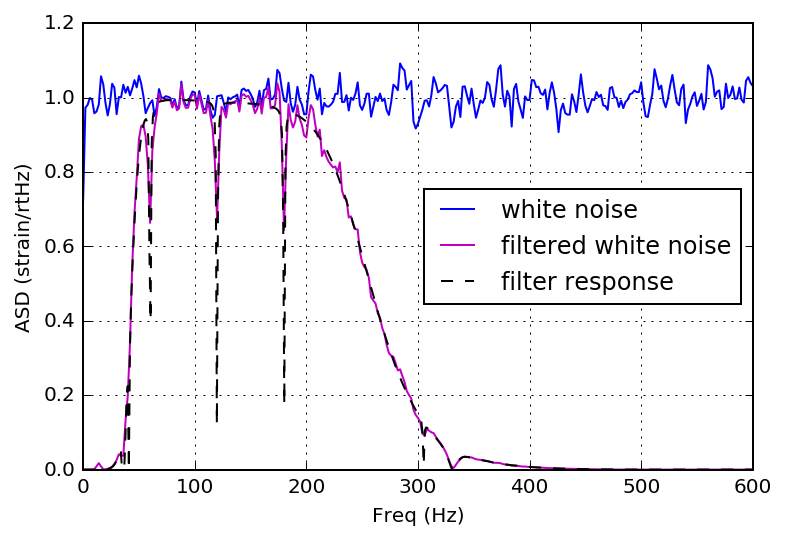

In [57]:
# get filter coefficients
coefs = get_filter_coefs(fs)

# generate random gaussian "data"
data = np.random.randn(128*fs)

# filter it:
resp = filter_data(data,coefs)

# compute the amplitude spectral density (ASD) of the original data, and the filtered data:
NFFT = fs/2
Pxx_data, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT)
Pxx_resp, freqs = mlab.psd(resp, Fs = fs, NFFT = NFFT)

# The asd is the square root; and let's normalize it to 1:
norm = np.sqrt(Pxx_data).mean()
asd_data = np.sqrt(Pxx_data)/norm
asd_resp = np.sqrt(Pxx_resp)/norm

# get the predicted filter frequency response using signal.freqz:
Nc = 2000
filt_resp = np.ones(Nc)
for coef in coefs:
    b,a = coef
    w,r = signal.freqz(b,a,worN=Nc)
    filt_resp = filt_resp*np.abs(r)
freqf = (fs * 0.5 / np.pi) * w
# We "double pass" the filtering using filtfilt, so we square the filter response
filt_resp = filt_resp**2

# plot the ASDs
plt.figure()
plt.plot(freqs,  asd_data,'b',label='white noise')
plt.plot(freqs,  asd_resp,'m',label='filtered white noise')
plt.plot(freqf, filt_resp,'k--',label='filter response')
plt.xlim([0,600])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='center right')
plt.savefig('GW150914_filter.png')

From the above, you can see that the gaussian noise (blue) is "white" - it is flat in frequency (all the way up to Nyquist frequency of 2048 Hz, but we'lve cut it off at 600 Hz to see the effect of filtering). You can see in the filtered data (magenta) the effects of the bandpassing and the notches.

Now let's filter the data, and plot the results:

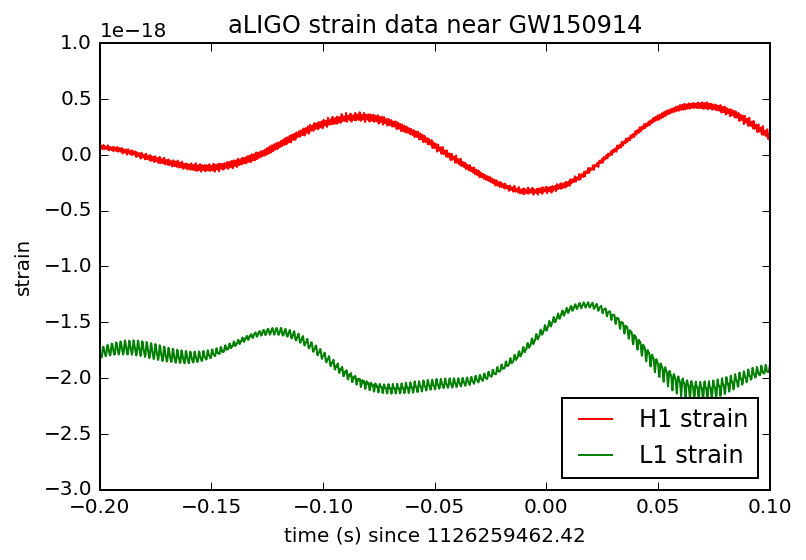

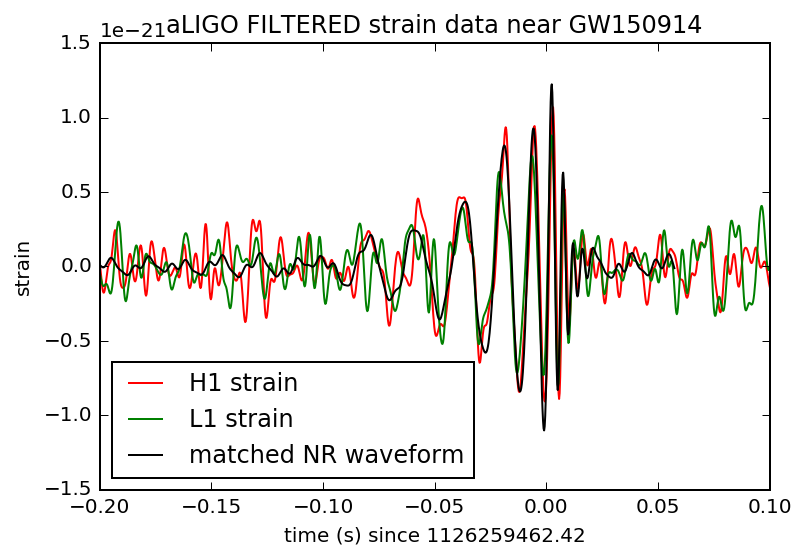

In [39]:
# filter the data:
strain_H1_filt = filter_data(strain_H1, coefs)
strain_L1_filt = filter_data(strain_L1, coefs)

# filter NR template as we do with the data:
NR_H1_filt = filter_data(NR_H1, coefs)

# plot the data prior to filtering:
plt.figure()
plt.plot(time-tevent,strain_H1,'r',label='H1 strain')
plt.plot(time-tevent,strain_L1,'g',label='L1 strain')
plt.xlim([-0.2,0.1])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend(loc='lower right')
plt.title('aLIGO strain data near GW150914')
plt.savefig('GW150914_H1_strain_unfiltered.png')

# plot the data after filtering:
# first, shift L1 by 7 ms, and invert. See the GW150914 detection paper for why!
strain_L1_fils = -np.roll(strain_L1_filt,int(0.007*fs))
# We also have to shift the NR template by 2 ms to get it to line up properly with the data
plt.figure()
plt.plot(time-tevent,strain_H1_filt,'r',label='H1 strain')
plt.plot(time-tevent,strain_L1_fils,'g',label='L1 strain')
plt.plot(NRtime+0.002,NR_H1_filt,'k',label='matched NR waveform')
plt.xlim([-0.2,0.1])
plt.ylim([-1.5e-21,1.5e-21])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend(loc='lower left')
plt.title('aLIGO FILTERED strain data near GW150914')
plt.savefig('GW150914_H1_strain_filtered.png')

The filtered data peak at around 1.e-21, 1000 times smaller than the scale in the first plot. The "DC" offset between H1 and L1 data visible in the first plot is no longer visible here; the bandpassing cuts off frequency components below around 40 Hz. 

Now, as with whitening, the signal is visible as an oscillation sweeping from low to high frequency from -0.10 seconds to 0, then damping down into the random noise. Again, it looks roughly the same in both detectors, after shifting and flipping the L1 data with respect to H1. It's exactly the kind of signal we expect from the inspiral, merger and ringdown of two massive black holes.

And as with whitening, the NR waveform looks, by eye, to be a good match to the data in both detectors; the signal is consistent with the waveform predicted from General Relativity.

## Make sound files

Make wav (sound) files from the filtered, downsampled data, +-2s around the event.

In [40]:
# make wav (sound) files from the whitened data, +-2s around the event.

from scipy.io import wavfile

# function to keep the data within integer limits, and write to wavfile:
def write_wavfile(filename,fs,data):
    d = np.int16(data/np.max(np.abs(data)) * 32767 * 0.9)
    wavfile.write(filename,int(fs), d)

tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 2.                     # seconds around the event

# index into the strain time series for this time interval:
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))

# write the files:
write_wavfile("GW150914_H1_whitenbp.wav",int(fs), strain_H1_whitenbp[indxt])
write_wavfile("GW150914_L1_whitenbp.wav",int(fs), strain_L1_whitenbp[indxt])
write_wavfile("GW150914_NR_whitenbp.wav",int(fs), NR_H1_whitenbp)


With good headphones, you'll hear a faint thump in the middle.

We can enhance this by increasing the frequency; 
this is the "audio" equivalent of the enhanced visuals that NASA employs on telescope images with "false color".

The code below will shift the data up by 400 Hz (by taking an FFT, shifting/rolling the frequency series, then inverse fft-ing). The resulting sound file will be noticibly more high-pitched, and the signal will be easier to hear.

In [41]:
# function that shifts frequency of a band-passed signal
def reqshift(data,fshift=100,sample_rate=4096):
    """Frequency shift the signal by constant
    """
    x = np.fft.rfft(data)
    T = len(data)/float(sample_rate)
    df = 1.0/T
    nbins = int(fshift/df)
    # print T,df,nbins,x.real.shape
    y = np.roll(x.real,nbins) + 1j*np.roll(x.imag,nbins)
    z = np.fft.irfft(y)
    return z

# parameters for frequency shift
fs = 4096
fshift = 400.
speedup = 1.
fss = int(float(fs)*float(speedup))

# shift frequency of the data
strain_H1_shifted = reqshift(strain_H1_whitenbp,fshift=fshift,sample_rate=fs)
strain_L1_shifted = reqshift(strain_L1_whitenbp,fshift=fshift,sample_rate=fs)
NR_H1_shifted = reqshift(NR_H1_whitenbp,fshift=fshift,sample_rate=fs)

# write the files:
write_wavfile("GW150914_H1_shifted.wav",int(fs), strain_H1_shifted[indxt])
write_wavfile("GW150914_L1_shifted.wav",int(fs), strain_L1_shifted[indxt])
write_wavfile("GW150914_NR_shifted.wav",int(fs), NR_H1_shifted)


## Downsampling from 16384 Hz to 4096 Hz

So far, we have been working with data sampled at fs=4096 Hz. This is entirely sufficient for signals with no frequency content above f_Nyquist = fs/2 = 2048 Hz, such as GW150914. 

We downsample to 4096 Hz to save on download time, disk space, and memory requirements. If, however, you are interested in signals with frequency content above 2048 Hz, you need the data sampled at the full rate of 16384 Hz. 

Here we demonstrate how to do that downsampling, and how it might limit you is you are interested in frequency content near 2048 Hz and above.

First, download a LOSC data file containing 32 seconds of data at the full 16384 Hz rate, and another downsampled at 4096 Hs, and put them in your working directory / folder:
* https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_16_V1-1126259446-32.hdf5
* https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V1-1126259446-32.hdf5

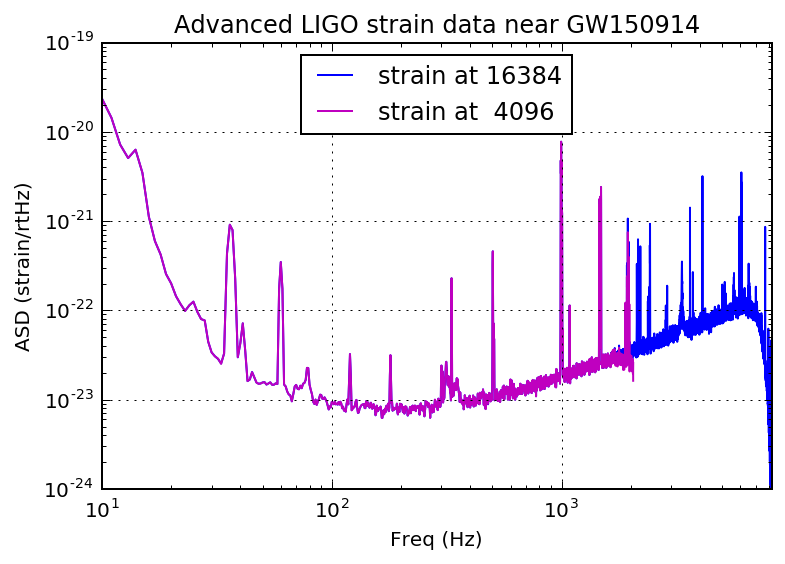

In [42]:
# read in the data at 16384 Hz and at 4096 Hz:
fn_16 = 'H-H1_LOSC_16_V1-1126259446-32.hdf5'
strain_16, time_16, chan_dict = rl.loaddata(fn_16, 'H1')
fn_4 = 'H-H1_LOSC_4_V1-1126259446-32.hdf5'
strain_4, time_4, chan_dict = rl.loaddata(fn_4, 'H1')

# Make PSDs of each:
fs = 16384
NFFT = 1*fs
Pxx_16, freqs_16 = mlab.psd(strain_16, Fs = fs, NFFT = NFFT)

fs = 4096
NFFT = 1*fs
Pxx_4, freqs_4 = mlab.psd(strain_4, Fs = fs, NFFT = NFFT)

fmin = 10
fmax = 8192

plt.figure()
plt.loglog(freqs_16, np.sqrt(Pxx_16),'b',label='strain at 16384')
plt.loglog(freqs_4,  np.sqrt(Pxx_4), 'm',label='strain at  4096')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_H1_ASD_16384.png')


Good agreement between 16384 Hz data and 4096 Hz data,
up to around f_Nyquist = 2048 Hz. Let's zoom in for a closer look:

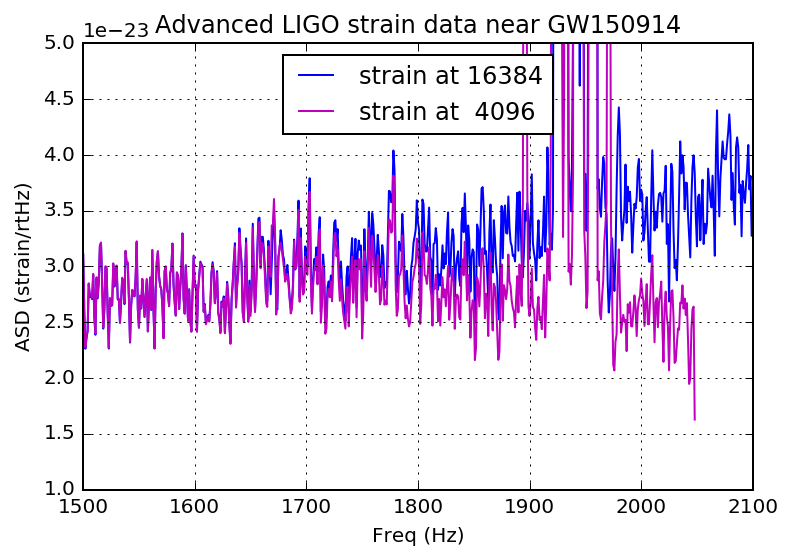

In [43]:
# Zoom in on the 1000-2000 Hz region:
fmin = 1500
fmax = 2100

plt.figure()
plt.plot(freqs_16, np.sqrt(Pxx_16),'b',label='strain at 16384')
plt.plot(freqs_4,  np.sqrt(Pxx_4), 'm',label='strain at  4096')
plt.axis([fmin, fmax, 1e-23, 5e-23])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_H1_ASD_16384_zoom.png')


The downsampled data deviate significantly from the original above ~1700 Hz. This is an undesirable, but inevitable result of downsampling (decimating). The plus side is that for frequencies less than 80% of Nyquist, the data are faithfully reproduced.

If frequency content above that point is important to you, you need to use the 16384 Hz data.

Else, you can save download time, disk space and memory by using the 4096 Hz data.

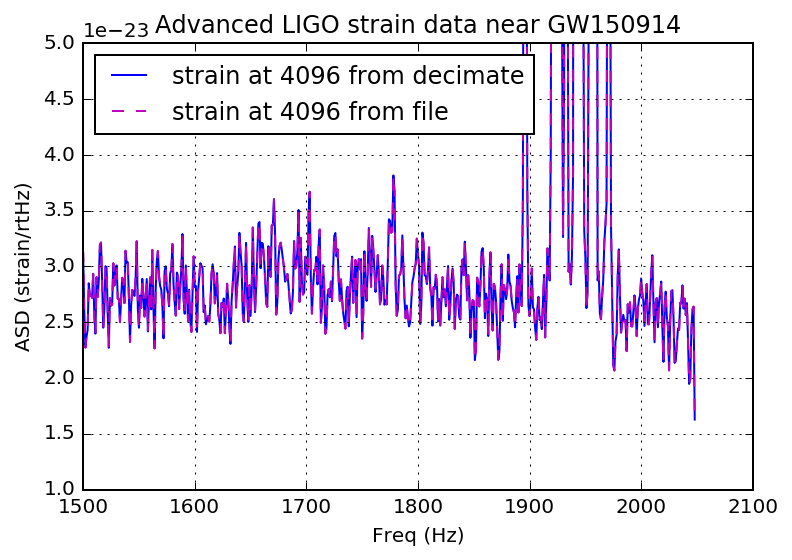

In [44]:
# Now downsample the 16384 Hz data and compare with the 4096 Hz data

factor = 4
numtaps = 61
strain_4new = signal.decimate(strain_16, factor, numtaps-1,ftype='fir')

fs = 4096
NFFT = 1*fs
Pxx_4new, freqs_4 = mlab.psd(strain_4new, Fs = fs, NFFT = NFFT)

fmin = 1500
fmax = 2100

plt.figure()
plt.plot(freqs_4, np.sqrt(Pxx_4new),'b',label='strain at 4096 from decimate')
plt.plot(freqs_4,  np.sqrt(Pxx_4), 'm--',label='strain at 4096 from file')
plt.axis([fmin, fmax, 1e-23, 5e-23])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper left')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_H1_ASD_4096_zoom.png')


The two traces are on top of each other, as expected. That's how we made the downsampled data in the first place.

From the above, we learn exactly how LOSC downsamples the strain time series from 16384 Hz to 4096 Hz 
(ie, using scipy.decimate), and that if you are interested in frequency content above ~ 1700 Hz,
use the 16384 Hz sample rate data instead.

## Data segments

As mentioned above, LIGO strain time series data has gaps (filled with NaNs) when the detectors are not taking valid ("science quality") data. Analyzing these data requires the user to loop over "segments" of valid data stretches.

For this GW150914 data release, the data have no gaps. Let's verify this, using the L1 data file containing 32 seconds of data sampled at 4096 Hz.

You are welcome to repeat this with H1 data, with files containing 4096 seconds of data, and with data sampled at 16384 Hz. All of the relevant files are listed near the top of this tutorial.

In [45]:
# read in the data at 4096 Hz:
fn = 'L-L1_LOSC_4_V1-1126259446-32.hdf5'
strain, time, chan_dict = rl.loaddata(fn, 'H1')

print "Contents of all the key, value pairs in chan_dict"
for keys,values in chan_dict.items():
    print(keys)
    print(values)

print "We see that all keys have 32 seconds of '1', meaning the data pass all data quality flags"
print "and have no HW injections, except there are CW injections in L1."
print " "
print 'Total number of non-NaNs in these data = ',np.sum(~np.isnan(strain))
print 'GPS start, GPS stop and length of  all data in this file = ',time[0], time[-1],len(strain)

# select the level of data quality; default is "DATA" but "CBC_CAT3" is a conservative choice:
DQflag = 'CBC_CAT3'
# readligo.py method for computing segments (start and stop times with continuous valid data):
segment_list = rl.dq_channel_to_seglist(chan_dict[DQflag])
print 'Number of segments with DQflag',DQflag,' = ',len(segment_list)

# loop over seconds and print out start, stop and length:
iseg = 0
for segment in segment_list:
    time_seg = time[segment]
    seg_strain = strain[segment]
    print 'GPS start, GPS stop and length of segment',iseg, \
        'in this file = ',time_seg[0], time_seg[-1], len(seg_strain)
    iseg = iseg+1
    # here is where you would insert code to analyze the data in this segment.
    
# now look at segments with no CBC hardware injections:
DQflag = 'NO_CBC_HW_INJ'
segment_list = rl.dq_channel_to_seglist(chan_dict['NO_CBC_HW_INJ'])
print 'Number of segments with DQflag',DQflag,' = ',len(segment_list)
iseg = 0
for segment in segment_list:
    time_seg = time[segment]
    seg_strain = strain[segment]
    print 'GPS start, GPS stop and length of segment',iseg, \
        'in this file = ',time_seg[0], time_seg[-1], len(seg_strain)
    iseg = iseg+1


Contents of all the key, value pairs in chan_dict
NO_BURST_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NO_CBC_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CBC_CAT1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BURST_CAT2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BURST_CAT1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CBC_CAT2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
DEFAULT
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CBC_CAT3
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NO_CW_HW_INJ
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
NO_STOCH_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NO_DETCHAR_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BURST_CAT3
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
DATA
[1 1 1 1

In [46]:
1126257414

from datetime import datetime


def from_gps(gps):
    """Convert a GPS time into a `datetime.datetime`.
    Parameters
    ----------
    gps : `LIGOTimeGPS`
        GPS time to convert
    Returns
    -------
    datetime : `datetime.datetime`
        ISO-format datetime equivalent of input GPS time
    """
    try:
        gps = LIGOTimeGPS(gps)
    except (ValueError, TypeError):
        gps = LIGOTimeGPS(float(gps))
    dt = Time(gps.seconds, gps.nanoseconds * 1e-9,
              format='gps', scale='utc').datetime
    if float(gps).is_integer():
        return dt.replace(microsecond=0)
    else:
        return dt
